# Seasons and Trends

This notebook's goal is to 1) identify seasons and trends 2) find effective ways to remove them in the target and feature parameters in modeling.. 

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np
import glob
import os

# load all csv files of Insead site. Concatenate them..
data_src = "../data"
all_files = glob.glob(os.path.join(data_src, "insead", "*.csv"))
df = pd.concat([pd.read_csv(f, low_memory=False) for f in all_files], ignore_index=True)

# minor changes
df = df.rename(columns={"Time Stamp": "timestamp"})
df = df.replace("\\N", np.nan)

# update data types. object is taken as default
dtypes = dict([(col, np.float64) for col in df.columns])
dtypes["timestamp"] = "datetime64[ns]"
df = df.astype(dtypes)

# change the index to timestamp.
df.index = df.timestamp

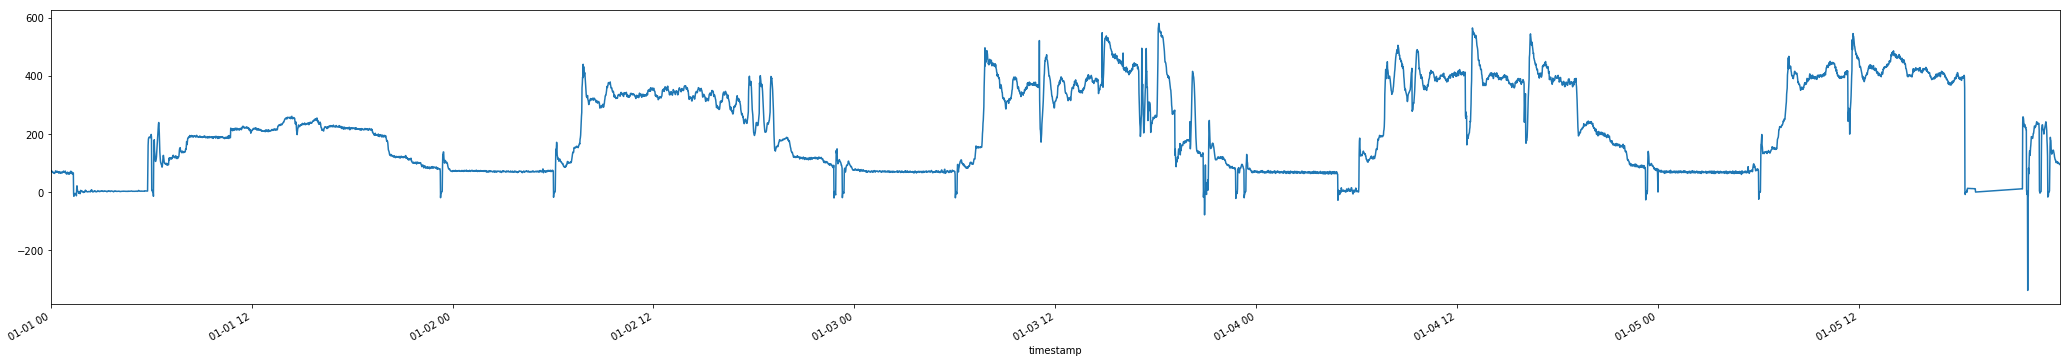

In [8]:
# lets analyze: loadsys, cwrhdr, drybulb, rh, ctkw and also.. cwshdr
fig, ax = plt.subplots(1,1, figsize=(36,6))
df["2017-01-01":"2017-01-05"].loadsys.plot(ax=ax)

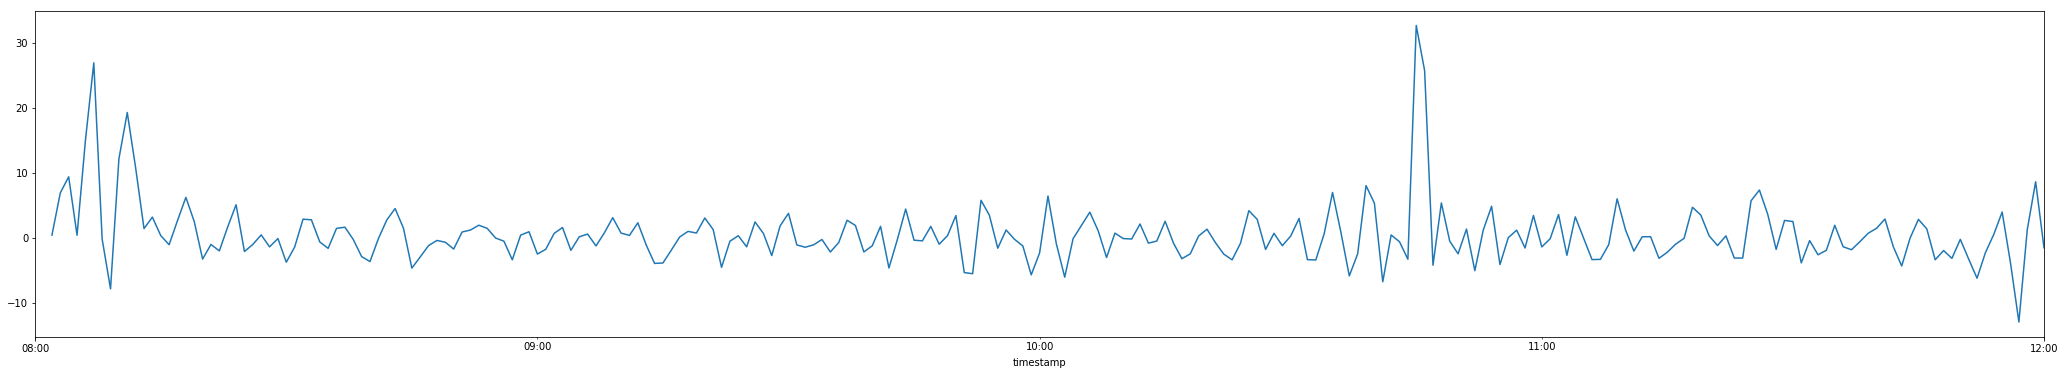

In [16]:
fig, ax = plt.subplots(1,1, figsize=(36,6))
period = df["2017-01-01 08:00":"2017-01-01 12:00"]
(period-period.shift(2)).loadsys.plot(ax=ax)